# Flower Recognition using CNN by Keras  
## my second work

from:https://www.kaggle.com/rajmehra03/flower-recognition-cnn-keras

In [1]:
import os
print(os.listdir('./flowers'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## 1.导入模块

In [13]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## 2.准备数据

### 2.1 从图片中得到train、valid

In [4]:
X=[]
Z=[]
IMG_SIZE=150
# 获得类别文件夹地址
FLOWER_DAISY_DIR='./flowers/daisy'
FLOWER_SUNFLOWER_DIR='./flowers/sunflower'
FLOWER_TULIP_DIR='./flowers/tulip'
FLOWER_DANDI_DIR='./flowers/dandelion'
FLOWER_ROSE_DIR='./flowers/rose'

In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)): # 对某一类中的一张图片
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img) # 获得图片的路径

        _, ftype = os.path.splitext(path) # 因为dandelion中有不是.jpg文件，所以要检查后缀
        if ftype == ".jpg": # 如果是.jpg文件
            img = cv2.imread(path,cv2.IMREAD_COLOR) # 读取图片
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE)) # 统一大小 150 * 150
            #img.shape = (150, 150, 3)
            #X.shape = (m, 150, 150, 3) m是图片数量
            #此时X的形式已经固定-tensor
            X.append(np.array(img)) # 存放图片数据 
            Z.append(str(label)) # 存放图片标签
#没有打乱顺序

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print('\n%d' %len(X))
#不能重复运行，不然X[]、Z[]会有重复数据

100%|██████████| 769/769 [00:04<00:00, 166.56it/s]
769



In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print('\n%d' %len(X))
#不能重复运行，不然X[]、Z[]会有重复数据

100%|██████████| 734/734 [00:03<00:00, 235.04it/s]
1503



In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print('\n%d' %len(X))
#不能重复运行，不然X[]、Z[]会有重复数据

100%|██████████| 984/984 [00:03<00:00, 265.34it/s]
2487



In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print('\n%d' %len(X))
#不能重复运行，不然X[]、Z[]会有重复数据

100%|██████████| 1055/1055 [00:04<00:00, 246.07it/s]
3539



In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print('\n%d' %len(X))
#不能重复运行，不然X[]、Z[]会有重复数据

100%|██████████| 784/784 [00:02<00:00, 274.12it/s]
4323



### 2.2 可视化一些随机图片

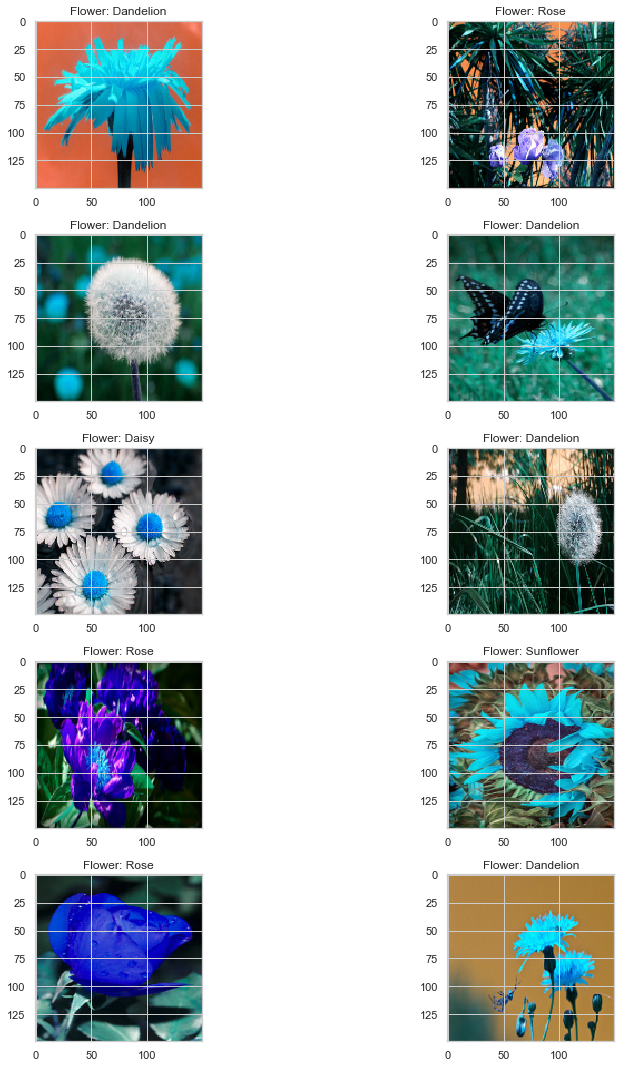

In [14]:
fig,ax=plt.subplots(5,2) # 显示5行2列的子图
fig.set_size_inches(15,15) # 显示图片的大小 15 * 15
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z)) #随机一张图的索引
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

有个问题：为什么长这个样子？也没有对图片进行变换啊？  

因为：cv2.IMREAD_COLOR：默认参数，读入一副彩色图片，忽略alpha通道

### 2.3 给标签编码

In [58]:
# Label都在Z[]中，将标签转为数字编码，再变为one-hot编码
le=LabelEncoder()
Y=le.fit_transform(Z) # 将标签变为数字，按标签的首字母排序，从0-4
Y=to_categorical(Y,5) # one-hot
# 现在X还是list，里面的元素是np.array(img)
X=np.array(X) # 将其转为np数组
X=X/255 # 归一化

# 此时X是图片数据，Y是标签数据

In [ ]:
#测试函数代码，不用运行
"""
A = ['daisy', 'daisy', 'dandelion', 'rose', 'sunflower', 'tulip', 'tulip']
test1 = le.fit_transform(A)
print(test1)
test1 = to_categorical(test1, 5)
print(test1)
test2 = le.transform(A)
print(test2)
"""
pass

### 2.4 划分train and valid 

In [34]:
# 这里的test其实是valid 而不是真正的test
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42) #test_size=0.25 表示测试集占总数的1/4

#打乱顺序

### *2.5 设定随机数种子(不设也没事，只是为了与原作者的代码校对)

In [17]:
# 固定随机数

np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)


## 3.构建模型

### 3.1 CNN

In [18]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512)) # 参数爆炸，电脑爆炸
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)        83040     
__________

### 3.2 LR Annealer 

*ReduceLROnPlateau():Reduce learning rate when a metric has stopped improving. *

当指标停止改善时，降低学习率。当学习停滞时，将学习率降低2-10倍  

好像和学习率衰减有些不同哦，学习率衰减是在lr前面乘以一个系数，与epoch的大小有关，即越训练，lr越小

* monitor：监视的指标
* factor：学习率降低的因子 new_lr = lr * factor
* patience: 当监视的指标没有提升，再迭代epoch = patience次,然后停止训练
* verbose：0: quiet, 1: update messages.
* min_lr: 最低学习率


In [19]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
reduce_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1, min_lr = 0.001)

### 3.3 数据增强减少过拟合

**ImageDataGenerator：图像生成器，可用于数据增强**  

参考： https://blog.csdn.net/qm5132/article/details/83758109<br>

https://www.jianshu.com/p/d23b5994db64

+ featurewise_center：图像原始值的3个通道 - 图像原始值的3个通道的均值(对每个channel而言)

+ samplewise_center：每个样本的均值为0 (对每个图像而言)

+ zca_whitening：去除样本之间的相关性

+ rotation_range：随机旋转的度数范围

+ zoom_range：随机缩放的范围

+ width_shift_range：水平平移范围

+ height_shift_range：垂直平移范围

+ horizontal_flip：水平随机翻转输入

+ vertical_flip：垂直随机翻转输入


In [20]:
# 随机旋转、随机缩放、随机水平垂直平移
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### 3.4 编译模型

In [21]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

### 3.5 训练模型 和 预测

In [36]:
#没有使用3.2节所讲的优化方法，使用history是为了训练过程可视化
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size) #x_train.shape[0] = m
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
25/25 [==============================] - 35s 1s/step - loss: 1.5355 - acc: 0.3050 - val_loss: 1.4364 - val_acc: 0.3922
Epoch 2/50
25/25 [==============================] - 26s 1s/step - loss: 1.2471 - acc: 0.4609 - val_loss: 1.1253 - val_acc: 0.5291
Epoch 3/50
25/25 [==============================] - 26s 1s/step - loss: 1.1103 - acc: 0.5591 - val_loss: 1.0781 - val_acc: 0.5504
Epoch 4/50
25/25 [==============================] - 26s 1s/step - loss: 1.0687 - acc: 0.5737 - val_loss: 1.0649 - val_acc: 0.5837
Epoch 5/50
25/25 [==============================] - 25s 1s/step - loss: 0.9540 - acc: 0.6291 - val_loss: 1.0031 - val_acc: 0.5911
Epoch 6/50
25/25 [==============================] - 22s 869ms/step - loss: 0.9463 - acc: 0.6289 - val_loss: 0.9272 - val_acc: 0.6346
Epoch 7/50
25/25 [==============================] - 22s 889ms/step - loss: 0.9116 - acc: 0.6470 - val_loss: 0.9271 - val_acc: 0.6226
Epoch 8/50
25/25 [==============================] - 25s 984ms/step - loss: 0.8435 - 

**loss: 0.2939 - acc: 0.8887 - val_loss: 0.7437 - val_acc: 0.7761**  

明显过拟合

## 4. 评估模型

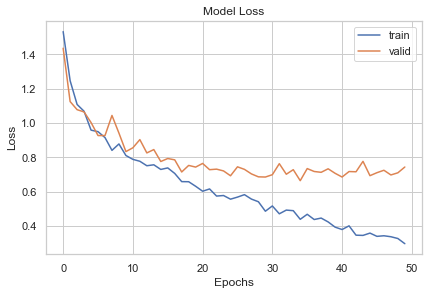

In [40]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.show()

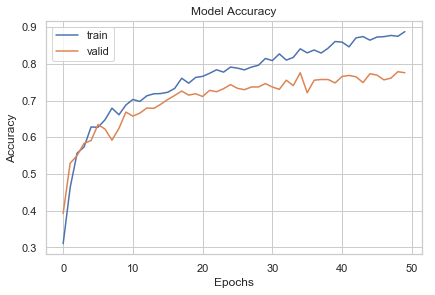

In [39]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'valid'])
plt.show()

## 5.Valid预测结果可视化

In [41]:
# getting predictions on val set.
pred=model.predict(x_test) #返回的是五类结果的概率
pred_digits=np.argmax(pred,axis=1) #返回最大值的索引，即类别

In [50]:
print(pred.shape)
print(pred_digits)

(1081, 5)
[3 0 3 ..., 3 4 3]


In [51]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]
# 保存的是index，再根据这个index去x_test中寻找图片
for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]): # 预测正确
        prop_class.append(i)
    if(len(prop_class)==8): # 取前8个
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]): #预测错误
        mis_class.append(i)
    if(len(mis_class)==8): # 也取前8个
        break

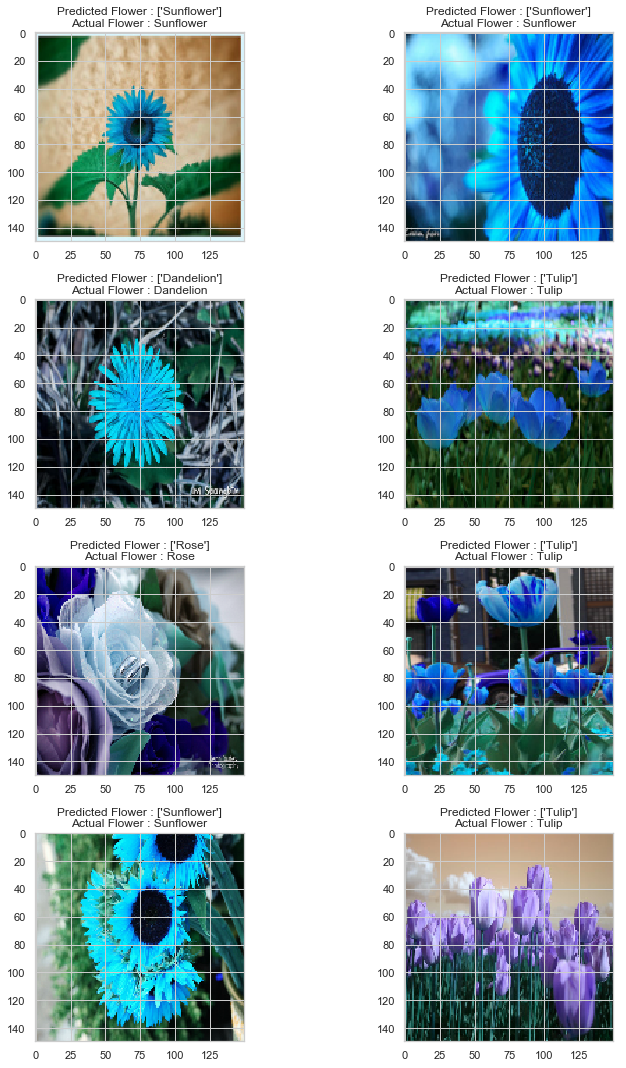

In [59]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2) # 4行2列的子图
fig.set_size_inches(15,15) # 每个子图的大小
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

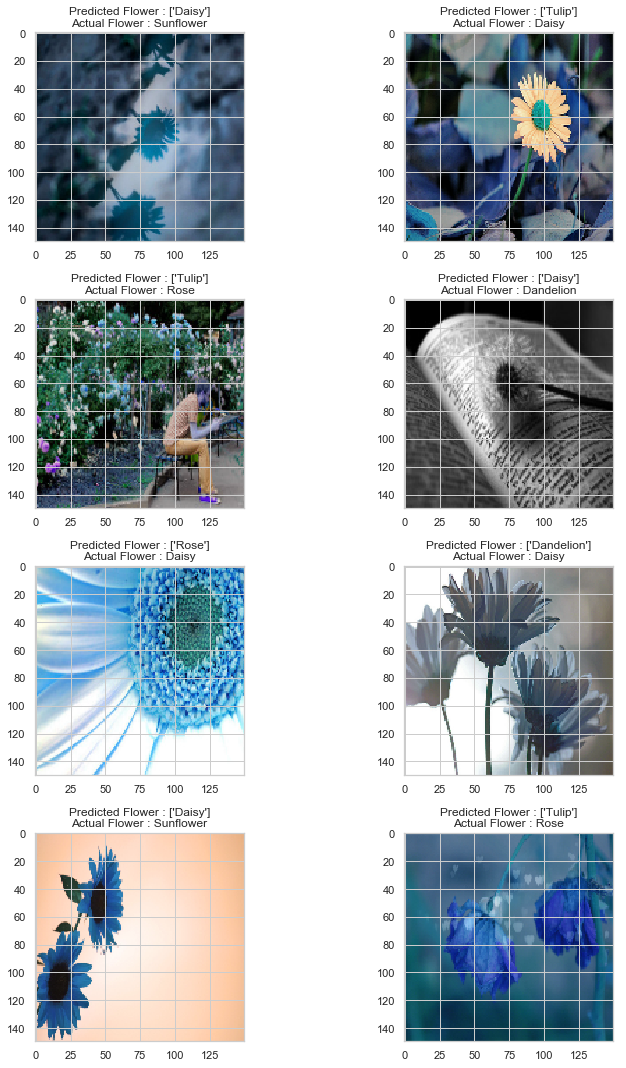

In [60]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1